In [1]:
import polars as pl
from utils.load_data import get_data

In [2]:
X_train, X_test, y_train, y_test = get_data("s")

## Fit Model

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [4]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", RandomForestClassifier(n_jobs=-2, n_estimators=100))
    ]
)

In [5]:
classifier = pipeline.fit(X_train, y_train)

In [6]:
classifier.classes_

array(['false', 'true'], dtype=object)

## Evaluation

In [7]:
from utils.plot import plot_eval
import sklearn.metrics as metrics

In [8]:
y_pred = classifier.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       false       0.94      0.95      0.94     15956
        true       0.95      0.94      0.94     16044

    accuracy                           0.94     32000
   macro avg       0.94      0.94      0.94     32000
weighted avg       0.94      0.94      0.94     32000



In [9]:
evaluation_reuslt = {
    "auc": metrics.roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]),
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "precision": metrics.precision_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "recall": metrics.recall_score(y_test, y_pred, pos_label='true'),  # type: ignore
    "f1": metrics.f1_score(y_test, y_pred, pos_label='true'), # type: ignore
}
evaluation_reuslt

{'auc': 0.9871901296878557,
 'accuracy': 0.94425,
 'precision': 0.9475831763967357,
 'recall': 0.9408501620543506,
 'f1': 0.9442046662913618}

/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


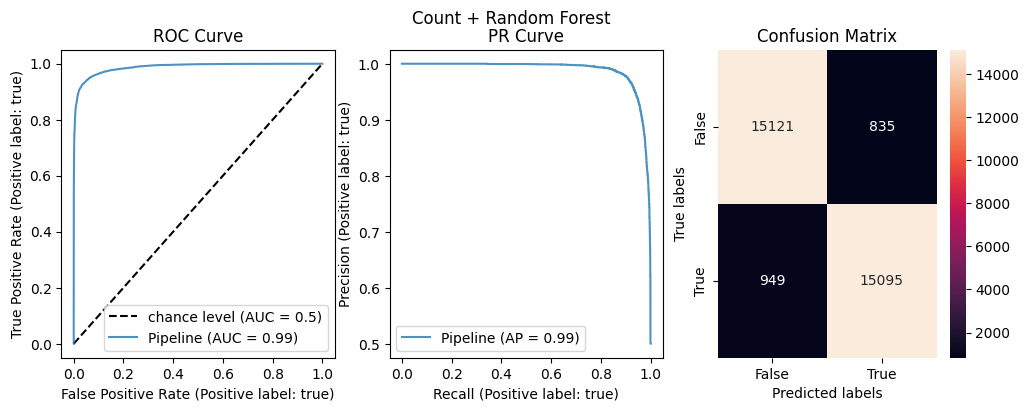

In [10]:
plt = plot_eval(X_test, y_test, y_pred, classifier, "Count + Random Forest")
plt.savefig("output/count_random_forest.png")

## LIAR Test

In [11]:
from utils.load_data import load_liar

X_liar, y_liar = load_liar()

In [12]:
from sklearn.metrics import classification_report

y_liar_pred = classifier.predict(X_liar)

print(classification_report(y_liar, y_liar_pred))

              precision    recall  f1-score   support

       false       0.64      0.31      0.42      8284
        true       0.35      0.69      0.46      4507

    accuracy                           0.44     12791
   macro avg       0.50      0.50      0.44     12791
weighted avg       0.54      0.44      0.43     12791



/home/kooler/dev/sw/sns-fake-content/model/utils/plot.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


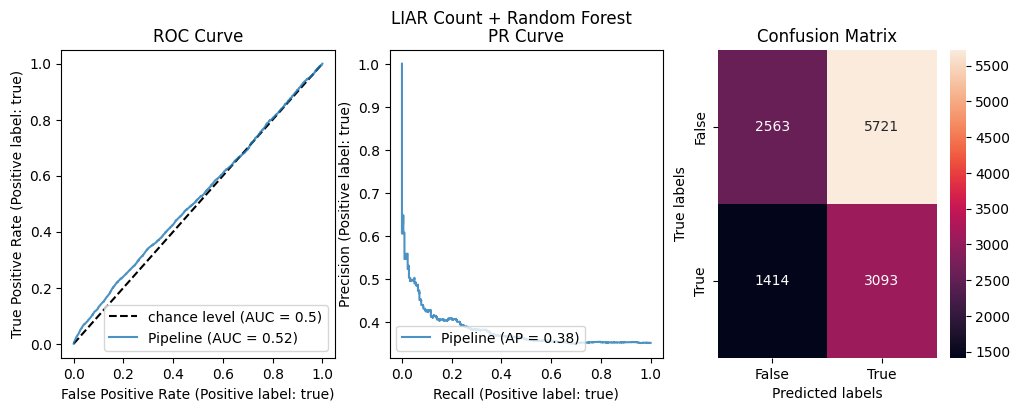

In [13]:
plt = plot_eval(X_liar, y_liar, y_liar_pred, classifier, "LIAR Count + Random Forest")
plt.savefig("output/count_random_forest_liar.png")

## Export model

In [14]:
from joblib import dump, load
dump(classifier, 'output/count_random_forest.joblib') 

['output/count_random_forest.joblib']

In [34]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

initial_type = [("text", StringTensorType([None,]))]
onx = convert_sklearn(classifier, initial_types=initial_type)
with open("output/count_random_forest.onnx", "wb") as f:
    f.write(onx.SerializeToString())


In [35]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy

sess = rt.InferenceSession("output/count_random_forest.onnx", providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [38]:
pred_onx = sess.run(None, {input_name: X_test})